In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [13]:
df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_test.csv')
print(df.head())

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      7    0    0    0    0    0    0    0    0    0  ...      0      0   
1      2    0    0    0    0    0    0    0    0    0  ...      0      0   
2      1    0    0    0    0    0    0    0    0    0  ...      0      0   
3      0    0    0    0    0    0    0    0    0    0  ...      0      0   
4      4    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


In [14]:
df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv')
print(df.head())

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [16]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [17]:
# Custom Dataset class for MNIST CSV data
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with MNIST data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        data = pd.read_csv(csv_file)
        self.labels = data.iloc[:, 0].values
        self.images = data.iloc[:, 1:].values.astype(np.float32)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = int(self.labels[idx])
        
        # Normalize image
        image = image / 255.0
        
        # Reshape to 28x28
        image = image.reshape(28, 28)
        
        # Convert to tensor
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [18]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # First convolutional block
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Second convolutional block
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten and fully connected layers
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [19]:
# Training function
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 99:
            print(f'Epoch: {epoch}, Batch: {batch_idx+1}, Loss: {running_loss/100:.3f}, Accuracy: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    return 100.*correct/total


In [21]:
# Function to show sample images from the dataset
def show_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze().numpy(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [22]:
# Main function
def main():
    # Hyperparameters
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 5
    
    # Load data
    print("Loading datasets...")
    try:
        train_dataset = MNISTDataset(csv_file='/kaggle/input/mnist-in-csv/mnist_train.csv')
        test_dataset = MNISTDataset(csv_file='/kaggle/input/mnist-in-csv/mnist_test.csv')
    except FileNotFoundError:
        print("Using default file paths...")
        train_dataset = MNISTDataset(csv_file='mnist_train.csv')
        test_dataset = MNISTDataset(csv_file='mnist_test.csv')
    
    # Show some sample images to verify data loading
    print("Showing sample images from the dataset...")
    show_sample_images(train_dataset)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print("Datasets loaded successfully!")
    
    # Initialize model
    model = CNN().to(device)
    print(model)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    print("Starting training...")
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(1, num_epochs + 1):
        train_acc = train(model, train_loader, optimizer, criterion, epoch)
        test_acc, _, _ = evaluate(model, test_loader)
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
    
    print("Training completed!")
    
    # Plot training and test accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()
    
    # Final evaluation
    print("Performing final evaluation...")
    final_acc, y_pred, y_true = evaluate(model, test_loader)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Save model
    torch.save(model.state_dict(), 'mnist_cnn_model.pth')
    print("Model saved as 'mnist_cnn_model.pth'")
    
    # Visualize some predictions
    def visualize_predictions(model, test_loader, num_samples=10):
        model.eval()
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        
        with torch.no_grad():
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
        images = images.cpu().numpy()
        
        fig, axes = plt.subplots(1, num_samples, figsize=(20, 3))
        for i in range(num_samples):
            axes[i].imshow(images[i][0], cmap='gray')
            axes[i].set_title(f'Pred: {predicted[i].item()}\nTrue: {labels[i].item()}')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.savefig('predictions.png')
        plt.show()
    
    visualize_predictions(model, test_loader)


Loading datasets...
Showing sample images from the dataset...


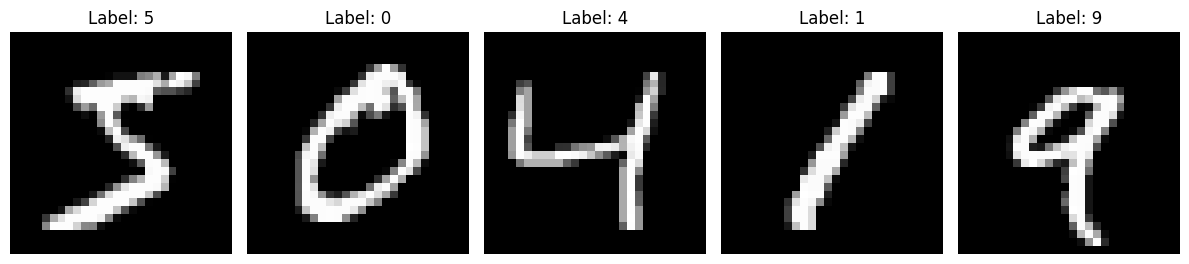

Datasets loaded successfully!
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Starting training...
Epoch: 1, Batch: 100, Loss: 1.051, Accuracy: 64.95%
Epoch: 1, Batch: 200, Loss: 0.404, Accuracy: 76.32%
Epoch: 1, Batch: 300, Loss: 0.260, Accuracy: 81.62%
Epoch: 1, Batch: 400, Loss: 0.211, Accuracy: 84.65%
Epoch: 1, Batch: 500, Loss: 0.205, Accuracy: 86.56%
Epoch: 1, Batch: 600, Loss: 0.176, Accuracy: 87.94%
Epoch: 1, Batch: 700, Loss: 0.167, Accuracy: 88.93%
Epoch: 1, Batch: 800, Loss: 0.150, Accuracy: 89.79%
Epoch: 1, Batch: 900, Loss: 0.131, Accuracy: 90.48%
Test Accuracy: 98.05%
E

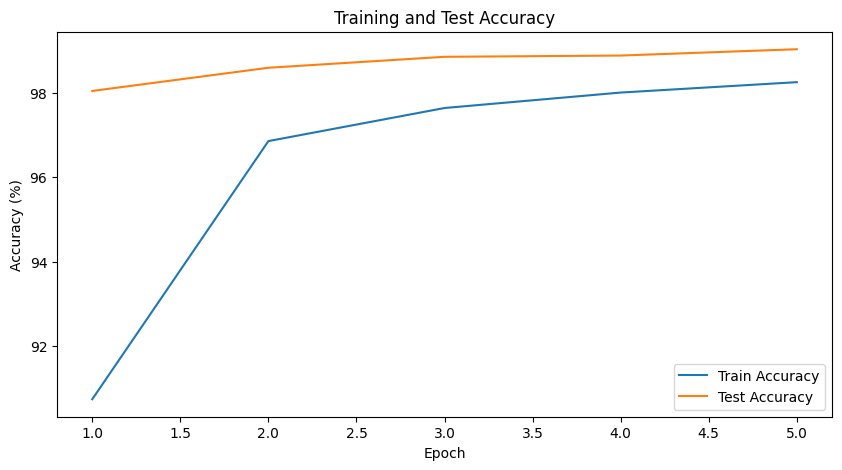

Performing final evaluation...
Test Accuracy: 99.04%


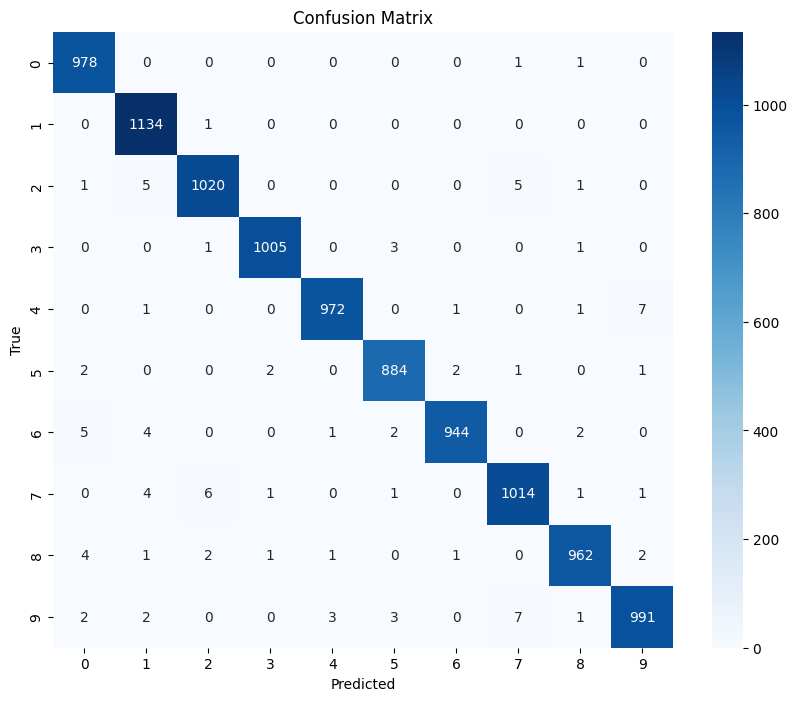


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Model saved as 'mnist_cnn_model.pth'


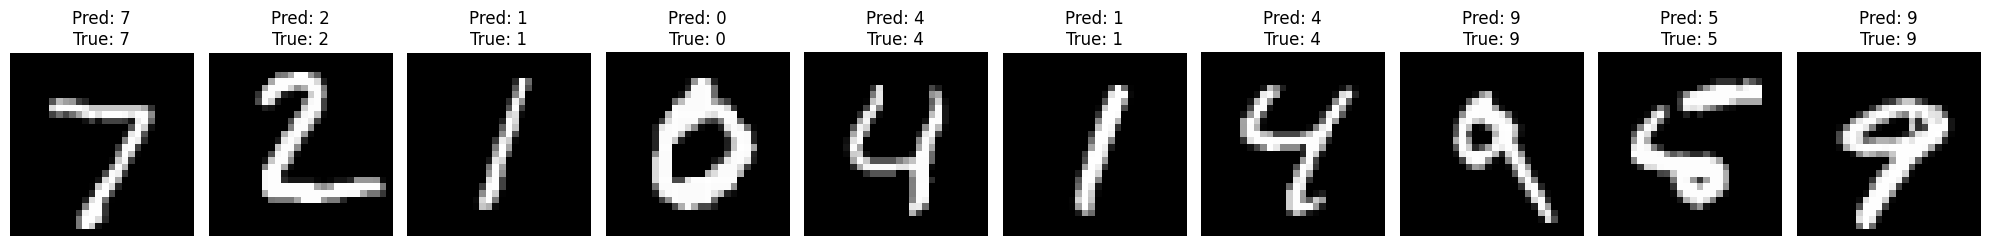

In [23]:
if __name__ == "__main__":
    main()